# **Car price prediction**

In [124]:
# STEP 0: import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#apis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
#modules
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#normal lib
from statistics import mean
import joblib
import seaborn as sns

# **STEP 1. LOOK AT THE BIG PICTURE DEON**
# tell briefly about car prices and what features have been used

In [125]:
#STEP 2: GET THE DATA 
raw_data = pd.read_csv(r'C:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\IntroToAI\car_price_prediction.csv')

In [126]:
# STEP 3: EDA 
# 3.1. briefly analyse the dataset with info, head and describe()
print("Dataset info:")
print(raw_data.info())

print("Data briefing: ")
print(raw_data.head())

print("Data describe: ")
raw_data.describe()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 no

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [127]:
# 3.1.1. Missing values:
print("Missing values: ")
print(raw_data.isna().sum())

Missing values: 
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [128]:
#reformat data
#cleaning the mileague
raw_data['Mileage'] = raw_data['Mileage'].str.extract('(\d+)').astype(int)

# extracting the enginer volume
raw_data['Turbo'] = raw_data['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
raw_data['Engine volume'] = raw_data['Engine volume'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# set empty levy = -1
raw_data['Levy'] = raw_data['Levy'].replace('-', '-1').astype(int)

# drop the unused data
raw_data = raw_data[raw_data['Levy'] > 0]

#production year to be a string

#drop the ID column
raw_data = raw_data.drop(columns = "ID")
raw_data.describe()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,13418.000000,13418.000000,13418.000000,13418.000000,1.341800e+04,13418.000000,13418.000000,13418.000000
mean,17298.492175,906.838128,2013.138024,2.317208,3.724392e+05,4.516619,6.894619,0.058131
std,19370.756312,461.867051,3.050424,0.872821,2.044857e+07,1.122808,4.465039,0.233999
min,1.000000,87.000000,1965.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000
25%,3607.000000,640.000000,2011.000000,1.800000,6.800000e+04,4.000000,4.000000,0.000000
50%,13500.000000,781.000000,2013.000000,2.000000,1.183655e+05,4.000000,4.000000,0.000000
75%,23436.000000,1058.000000,2015.000000,2.500000,1.792000e+05,4.000000,12.000000,0.000000
max,872946.000000,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000,1.000000


In [129]:
cols=raw_data.columns
num_cols = raw_data._get_numeric_data()
num_cols= list(num_cols.columns)
cat_cols = list(set(cols) - set(num_cols))
cat_cols.sort()

print(f"Numerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")
print(raw_data['Levy'].value_counts()) 


Numerical features: ['Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Turbo']
Categorical features: ['Category', 'Color', 'Doors', 'Drive wheels', 'Fuel type', 'Gear box type', 'Leather interior', 'Manufacturer', 'Model', 'Wheel']
Levy
765     486
891     461
639     410
640     405
1017    298
       ... 
3156      1
2908      1
1279      1
1719      1
1901      1
Name: count, Length: 558, dtype: int64


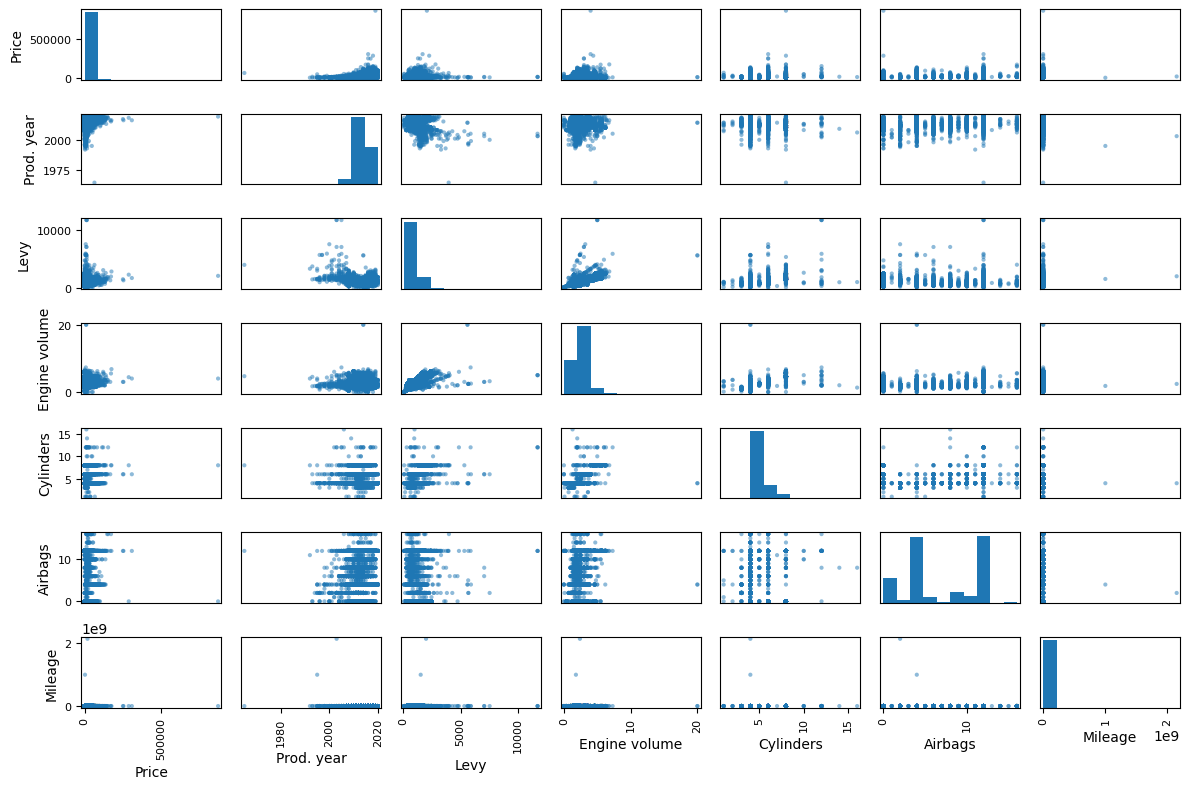

In [130]:
# 3.x. scatter matrix of numerical data
from pandas.plotting import scatter_matrix
def scatter(raw_data):
	attributes = ['Price', 'Prod. year', 'Levy', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(raw_data[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(raw_data)

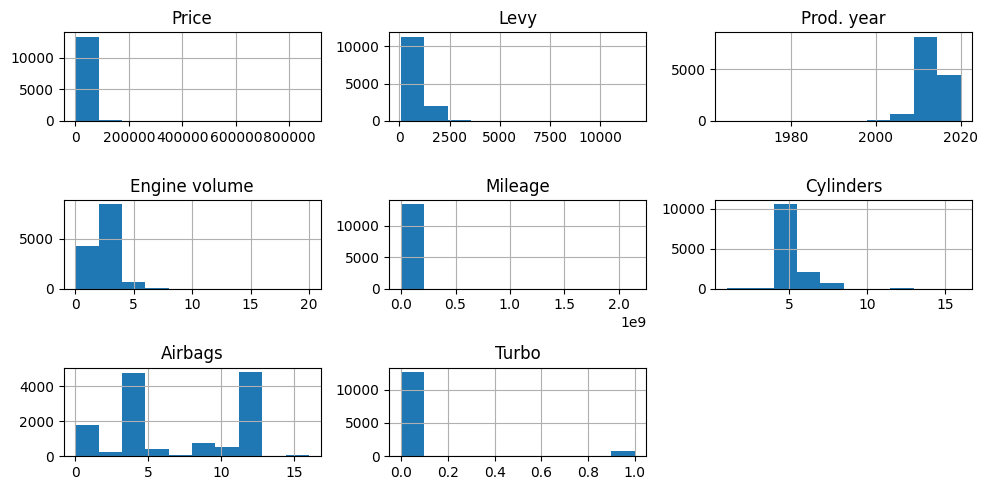

In [131]:
raw_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10


In [132]:
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix)

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000  0.063291    0.289959       0.032952 -0.003339   
Levy           0.063291  1.000000   -0.237967       0.648215  0.023624   
Prod. year     0.289959 -0.237967    1.000000      -0.103419 -0.049162   
Engine volume  0.032952  0.648215   -0.103419       1.000000 -0.000641   
Mileage       -0.003339  0.023624   -0.049162      -0.000641  1.000000   
Cylinders      0.016204  0.588695   -0.146251       0.801846 -0.004611   
Airbags       -0.163088  0.081107    0.056999       0.197155 -0.010990   
Turbo          0.135726 -0.022606   -0.040896      -0.086788  0.030270   

               Cylinders   Airbags     Turbo  
Price           0.016204 -0.163088  0.135726  
Levy            0.588695  0.081107 -0.022606  
Prod. year     -0.146251  0.056999 -0.040896  
Engine volume   0.801846  0.197155 -0.086788  
Mileage        -0.004611 -0.010990  0.030270  
Cylinders       1.000000  0.147975 -0.008784  
Airb

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000  0.063291    0.289959       0.032952 -0.003339   
Levy           0.063291  1.000000   -0.237967       0.648215  0.023624   
Prod. year     0.289959 -0.237967    1.000000      -0.103419 -0.049162   
Engine volume  0.032952  0.648215   -0.103419       1.000000 -0.000641   
Mileage       -0.003339  0.023624   -0.049162      -0.000641  1.000000   
Cylinders      0.016204  0.588695   -0.146251       0.801846 -0.004611   
Airbags       -0.163088  0.081107    0.056999       0.197155 -0.010990   
Turbo          0.135726 -0.022606   -0.040896      -0.086788  0.030270   

               Cylinders   Airbags     Turbo  
Price           0.016204 -0.163088  0.135726  
Levy            0.588695  0.081107 -0.022606  
Prod. year     -0.146251  0.056999 -0.040896  
Engine volume   0.801846  0.197155 -0.086788  
Mileage        -0.004611 -0.010990  0.030270  
Cylinders       1.000000  0.147975 -0.008784  
Airb

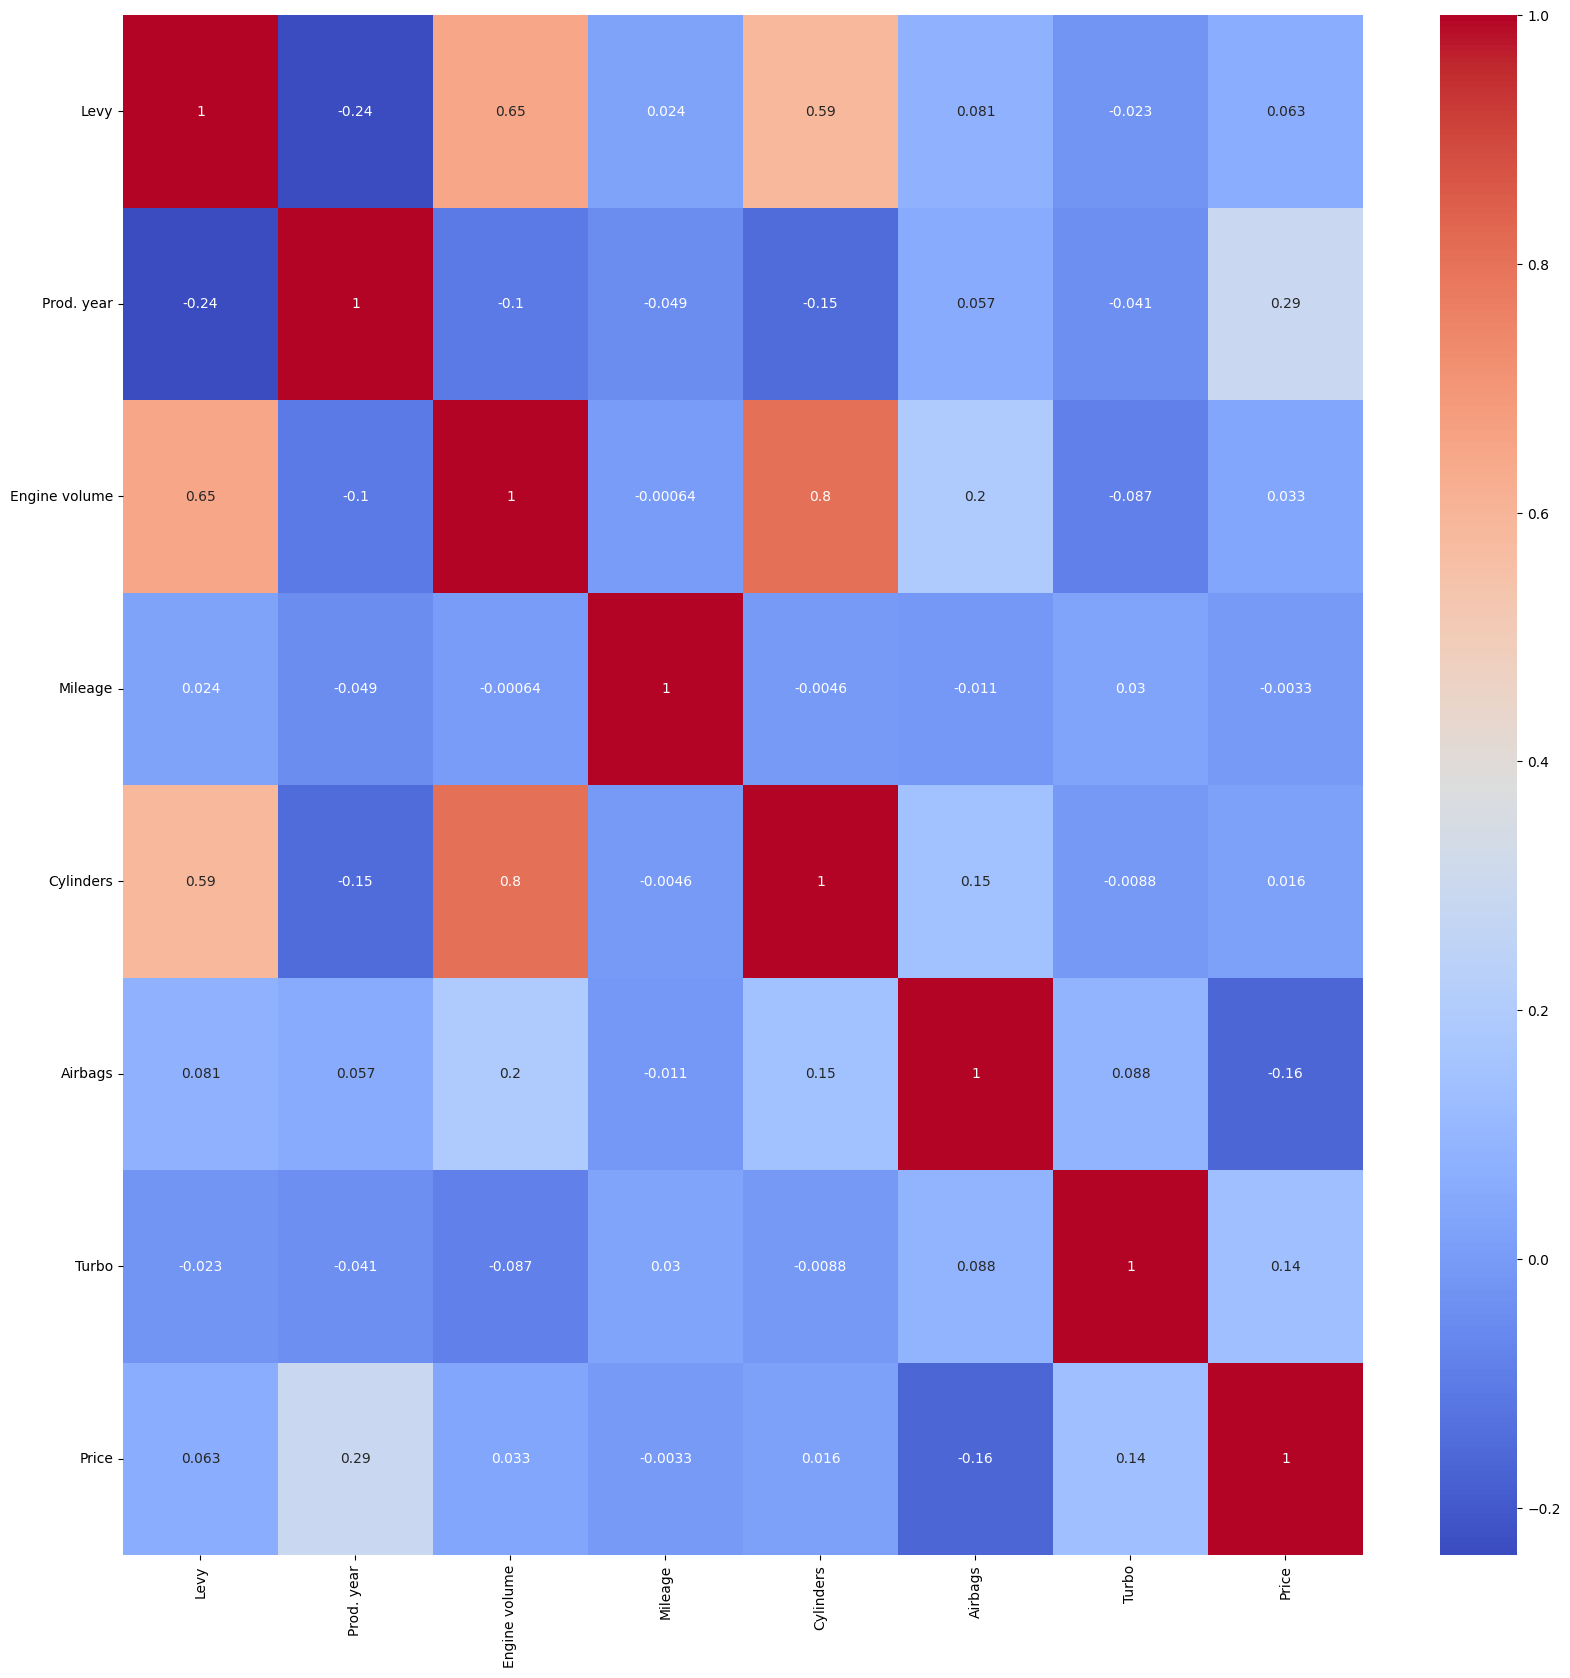

In [133]:
# 3.4 Correlation matrix
corr_matrix = raw_data.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price"].sort_values(ascending=False)) # print correlation b/w a feature and other features


columns = list(corr_matrix.columns)
columns.remove('Price')
columns.append('Price')
corr_matrix = corr_matrix. loc[columns, columns]

# Create a heatmap from the correlation matrix
plt. figure(figsize=(20, 20))
sns. heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [134]:
# Pair plot
# sns.pairplot(raw_data)
# plt.show()

In [135]:
# # 3.x Try combining features
# raw_data["AREA PER ROOM"] = raw_data["AREA IN M2"] / raw_data["NUMBER OF BEDROOMS"] 
# corr_matrix = raw_data.corr(numeric_only=True)
# print(corr_matrix["PRICE IN MILLION VND"].sort_values(ascending=False)) # print correlation b/w a feature and other features
# raw_data.drop(columns = ["AREA PER ROOM", "TOTAL NUMBER OF ROOMS"], inplace=True) # remove experiment columns

# EDA on categorical features

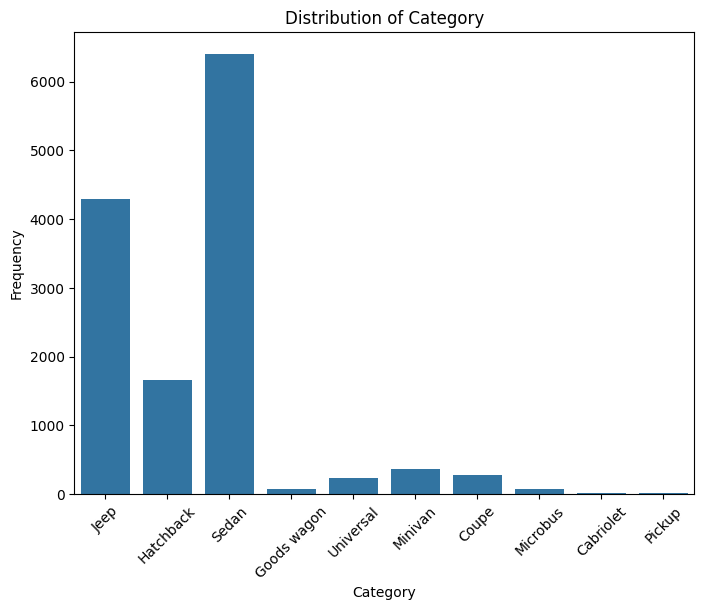

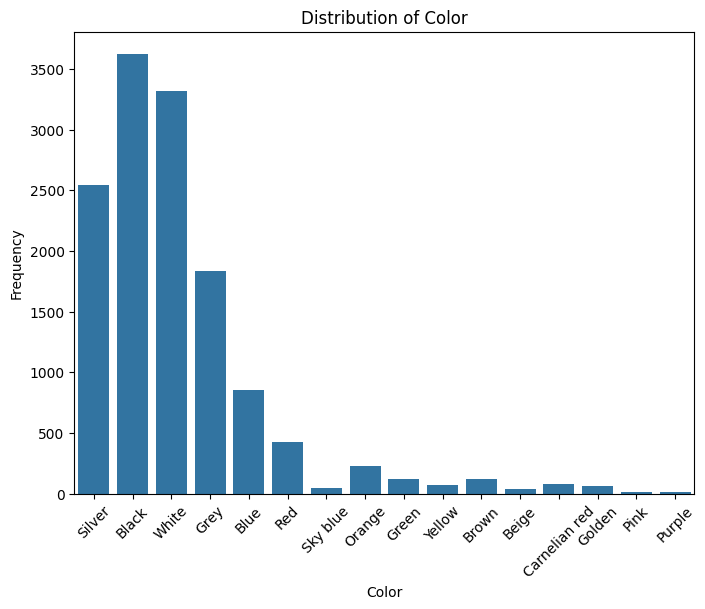

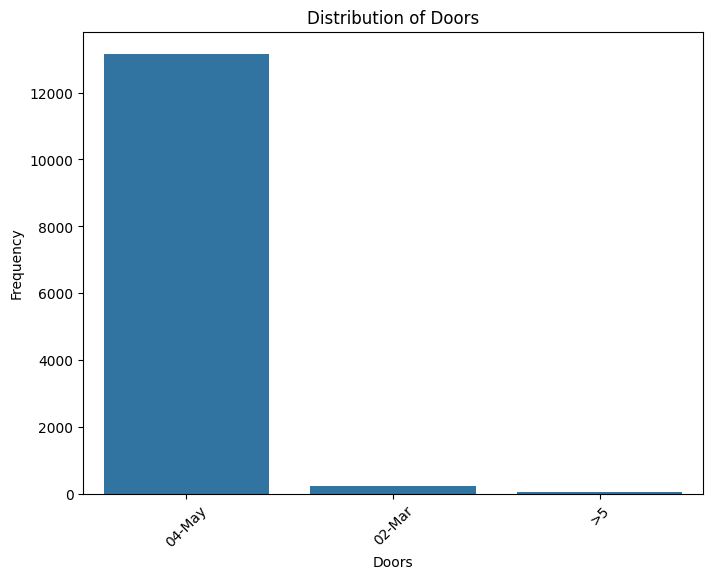

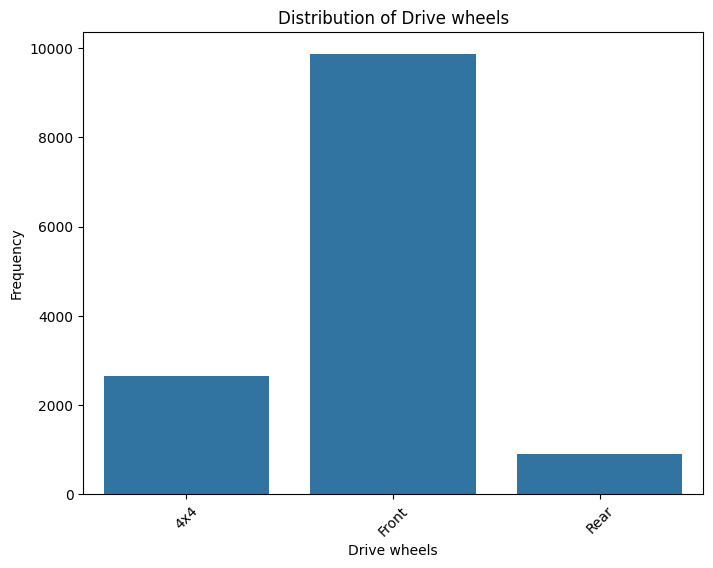

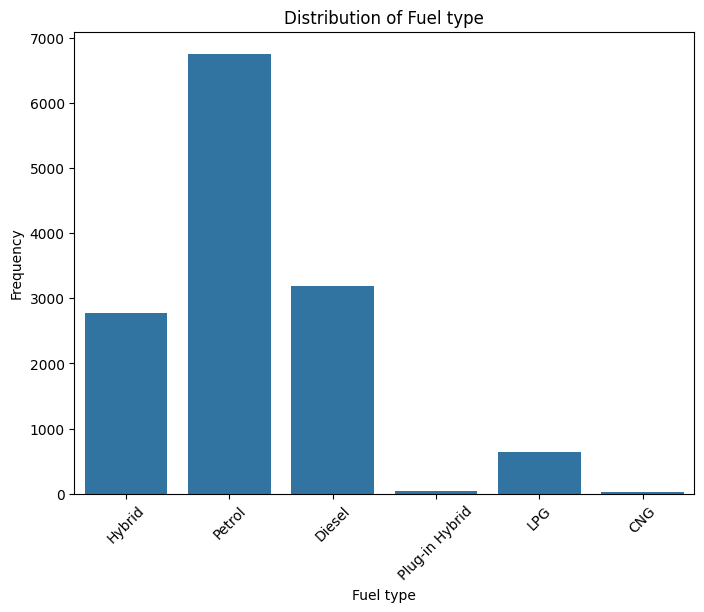

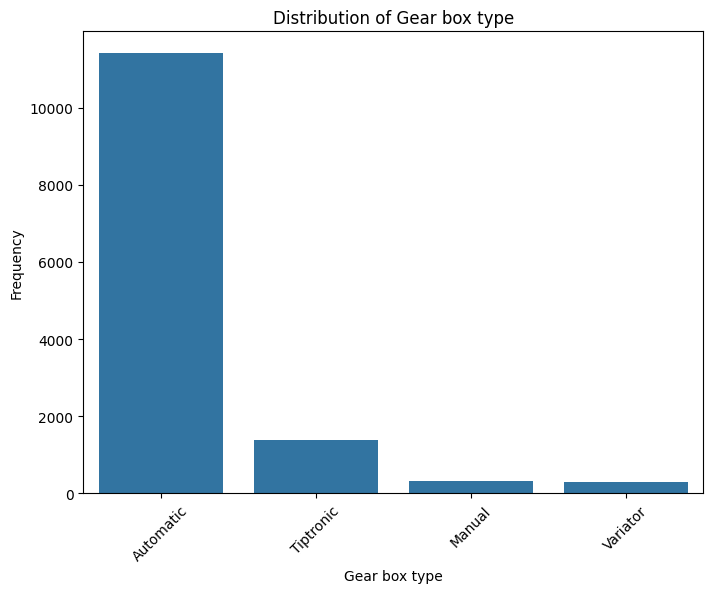

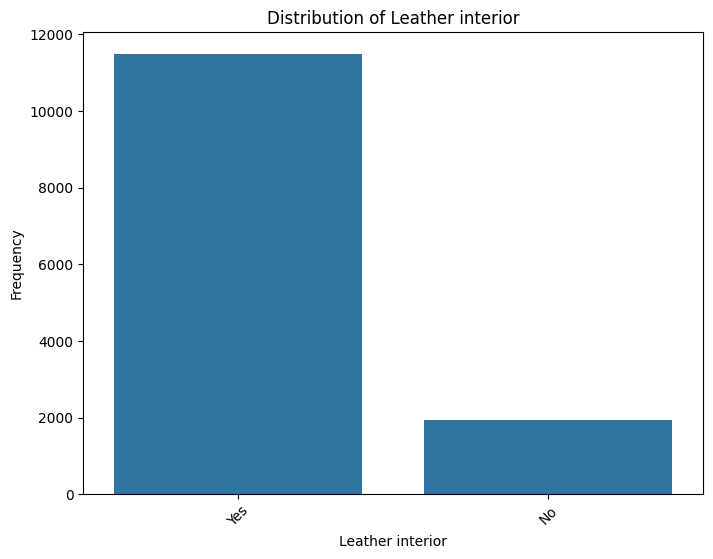

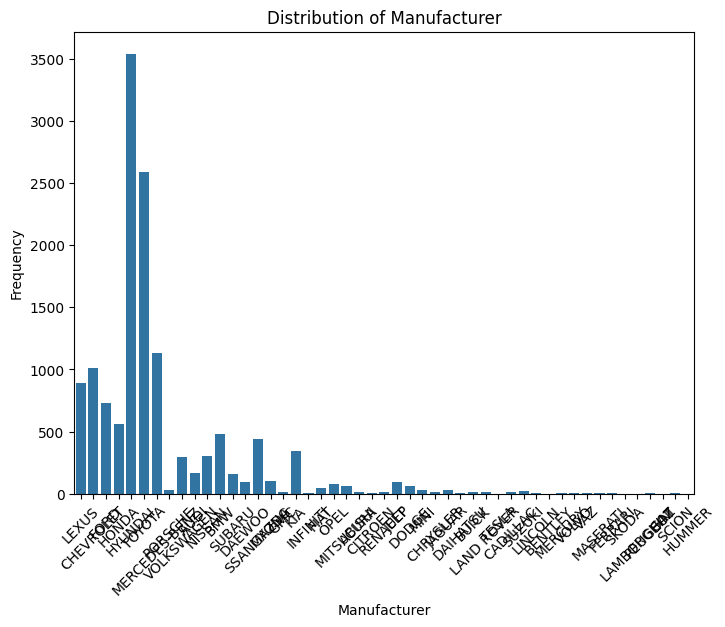

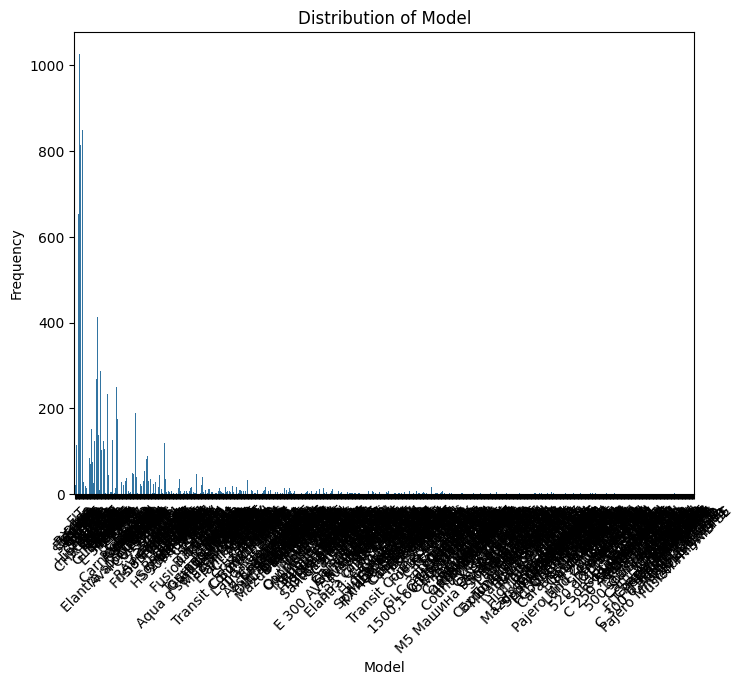

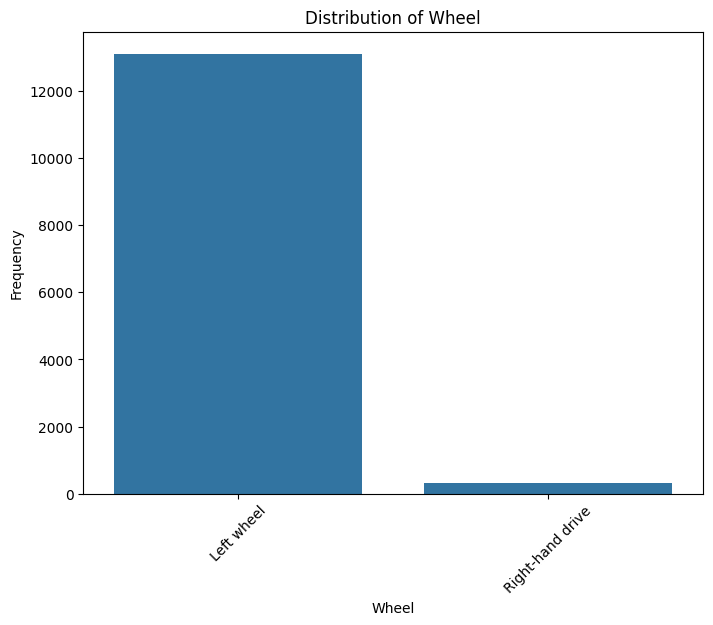

In [136]:
for feature in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, data=raw_data)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()
# print(cat_cols)

# STEP 4. PREPARE THE DATA 


In [137]:
# 4.1 Remove unused features
#print(raw_data)

In [138]:
# Check normality summary
def normality_sum(df):
    num_col = df.select_dtypes(include=[np.number]).columns

    result = []
    for col in num_col:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        result.append({
            'Variable' : col,
            'Skewness' : skewness,
            'Kurtosis' : kurtosis,
            'Mean' : df[col].mean(),
            'Median' : df[col].median(),
            'Std Dev' : df[col].std(),
            'Potential Normal' : abs(skewness) <= 1 and abs(kurtosis) <= 3
        })

    return pd.DataFrame(result)

normality_df = normality_sum(raw_data.drop(['Price'], axis =1))
print("Summary")
print(normality_df)

Summary
        Variable   Skewness     Kurtosis           Mean    Median  \
0           Levy   5.449954    85.727144     906.838128     781.0   
1     Prod. year  -1.036890     7.128399    2013.138024    2013.0   
2  Engine volume   2.559402    27.117056       2.317208       2.0   
3        Mileage  95.003074  9486.531518  372439.222015  118365.5   
4      Cylinders   2.269514     6.296835       4.516619       4.0   
5        Airbags  -0.023363    -1.457778       6.894619       4.0   
6          Turbo   3.777231    12.269301       0.058131       0.0   

        Std Dev  Potential Normal  
0  4.618671e+02             False  
1  3.050424e+00             False  
2  8.728212e-01             False  
3  2.044857e+07             False  
4  1.122808e+00             False  
5  4.465039e+00              True  
6  2.339995e-01             False  


In [139]:
def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    iqr = Q3 - Q1
    lower_bound = Q1 - factor * iqr
    upper_bound = Q3 + factor * iqr
    return lower_bound, upper_bound

# Assuming raw_data is a DataFrame and num_cols is a list of numerical columns
data_no_outliers = raw_data.copy()

# Remove rows where 'price' is less than 500
data_no_outliers = data_no_outliers[data_no_outliers['Price'] >= 500]

attributes = num_cols

for attribute in attributes:
    low, high = remove_outliers_iqr(data_no_outliers[attribute], factor=1.5)
    print(attribute, low, high)
    # Filter out rows where the attribute is an outlier
    outliers = (data_no_outliers[attribute] < low) | (data_no_outliers[attribute] > high)
    
    # Drop the outlier rows
    data_no_outliers = data_no_outliers[~outliers]

data_no_outliers.describe()


Price -19993.5 52138.5
Levy 27.0 1659.0
Prod. year 2005.0 2021.0
Engine volume 0.7500000000000002 3.55
Mileage -80000.0 320000.0
Cylinders 4.0 4.0
Airbags -8.0 24.0
Turbo 0.0 0.0


,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,8106.000000,8106.000000,8106.000000,8106.000000,8106.000000,8106.0,8106.000000,8106.0
mean,17472.718110,757.585862,2013.380459,1.969418,113930.492351,4.0,6.260794,0.0
std,12455.533477,231.642750,2.650915,0.385785,64895.607275,0.0,4.004665,0.0
min,549.000000,247.000000,2005.000000,0.800000,0.000000,4.0,0.000000,0.0
25%,8154.000000,607.000000,2012.000000,1.600000,65155.250000,4.0,4.000000,0.0
50%,15681.000000,753.000000,2013.000000,2.000000,109000.000000,4.0,4.000000,0.0
75%,23644.750000,880.000000,2015.000000,2.400000,152511.000000,4.0,12.000000,0.0
max,52106.000000,1659.000000,2020.000000,3.500000,320000.000000,4.0,16.000000,0.0


c:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\.conda\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\.conda\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\Users\lnkhu\OneDrive\Desktop\rmit\Modelling\.conda\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


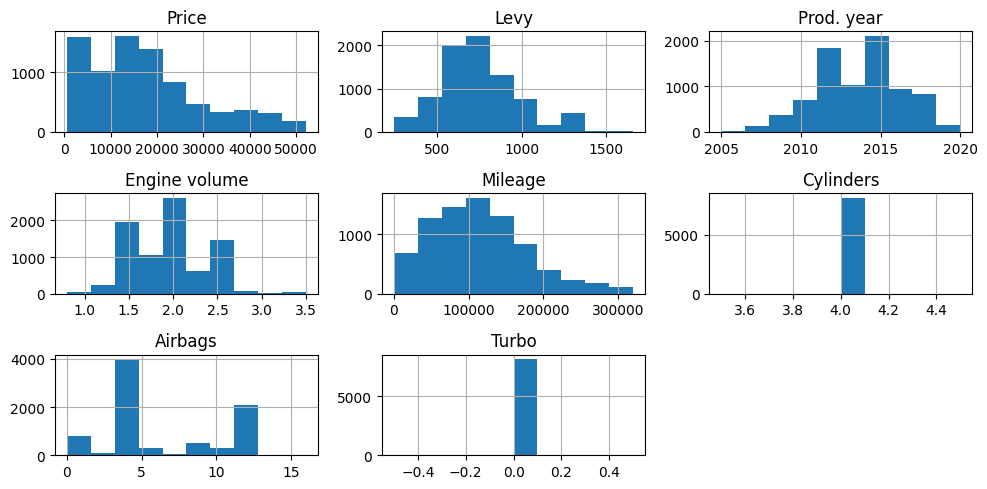

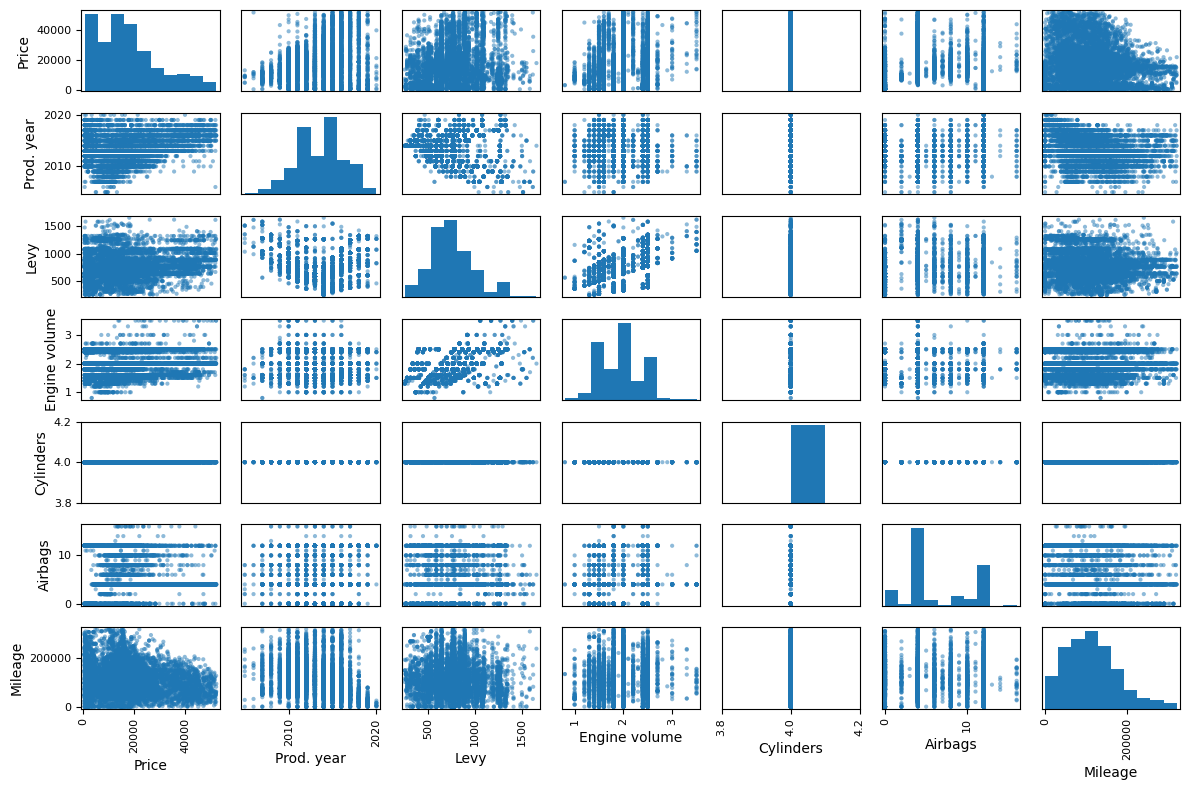

In [140]:
data_no_outliers.hist(figsize=(10,5)) #bins: no. of intervals
plt.tight_layout()

from pandas.plotting import scatter_matrix
def scatter(data_no_outliers):
	attributes = ['Price', 'Prod. year', 'Levy', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage'	]
	scatter_matrix(data_no_outliers[attributes], figsize=(12, 8))
	plt.tight_layout()
	plt.show()
scatter(data_no_outliers)

                  Price      Levy  Prod. year  Engine volume   Mileage  \
Price          1.000000  0.151910    0.303984       0.112916 -0.196925   
Levy           0.151910  1.000000    0.009216       0.378750 -0.102245   
Prod. year     0.303984  0.009216    1.000000       0.068672 -0.328634   
Engine volume  0.112916  0.378750    0.068672       1.000000  0.065347   
Mileage       -0.196925 -0.102245   -0.328634       0.065347  1.000000   
Cylinders           NaN       NaN         NaN            NaN       NaN   
Airbags       -0.265979  0.025047    0.144169       0.211748 -0.045879   
Turbo               NaN       NaN         NaN            NaN       NaN   

               Cylinders   Airbags  Turbo  
Price                NaN -0.265979    NaN  
Levy                 NaN  0.025047    NaN  
Prod. year           NaN  0.144169    NaN  
Engine volume        NaN  0.211748    NaN  
Mileage              NaN -0.045879    NaN  
Cylinders            NaN       NaN    NaN  
Airbags              NaN 

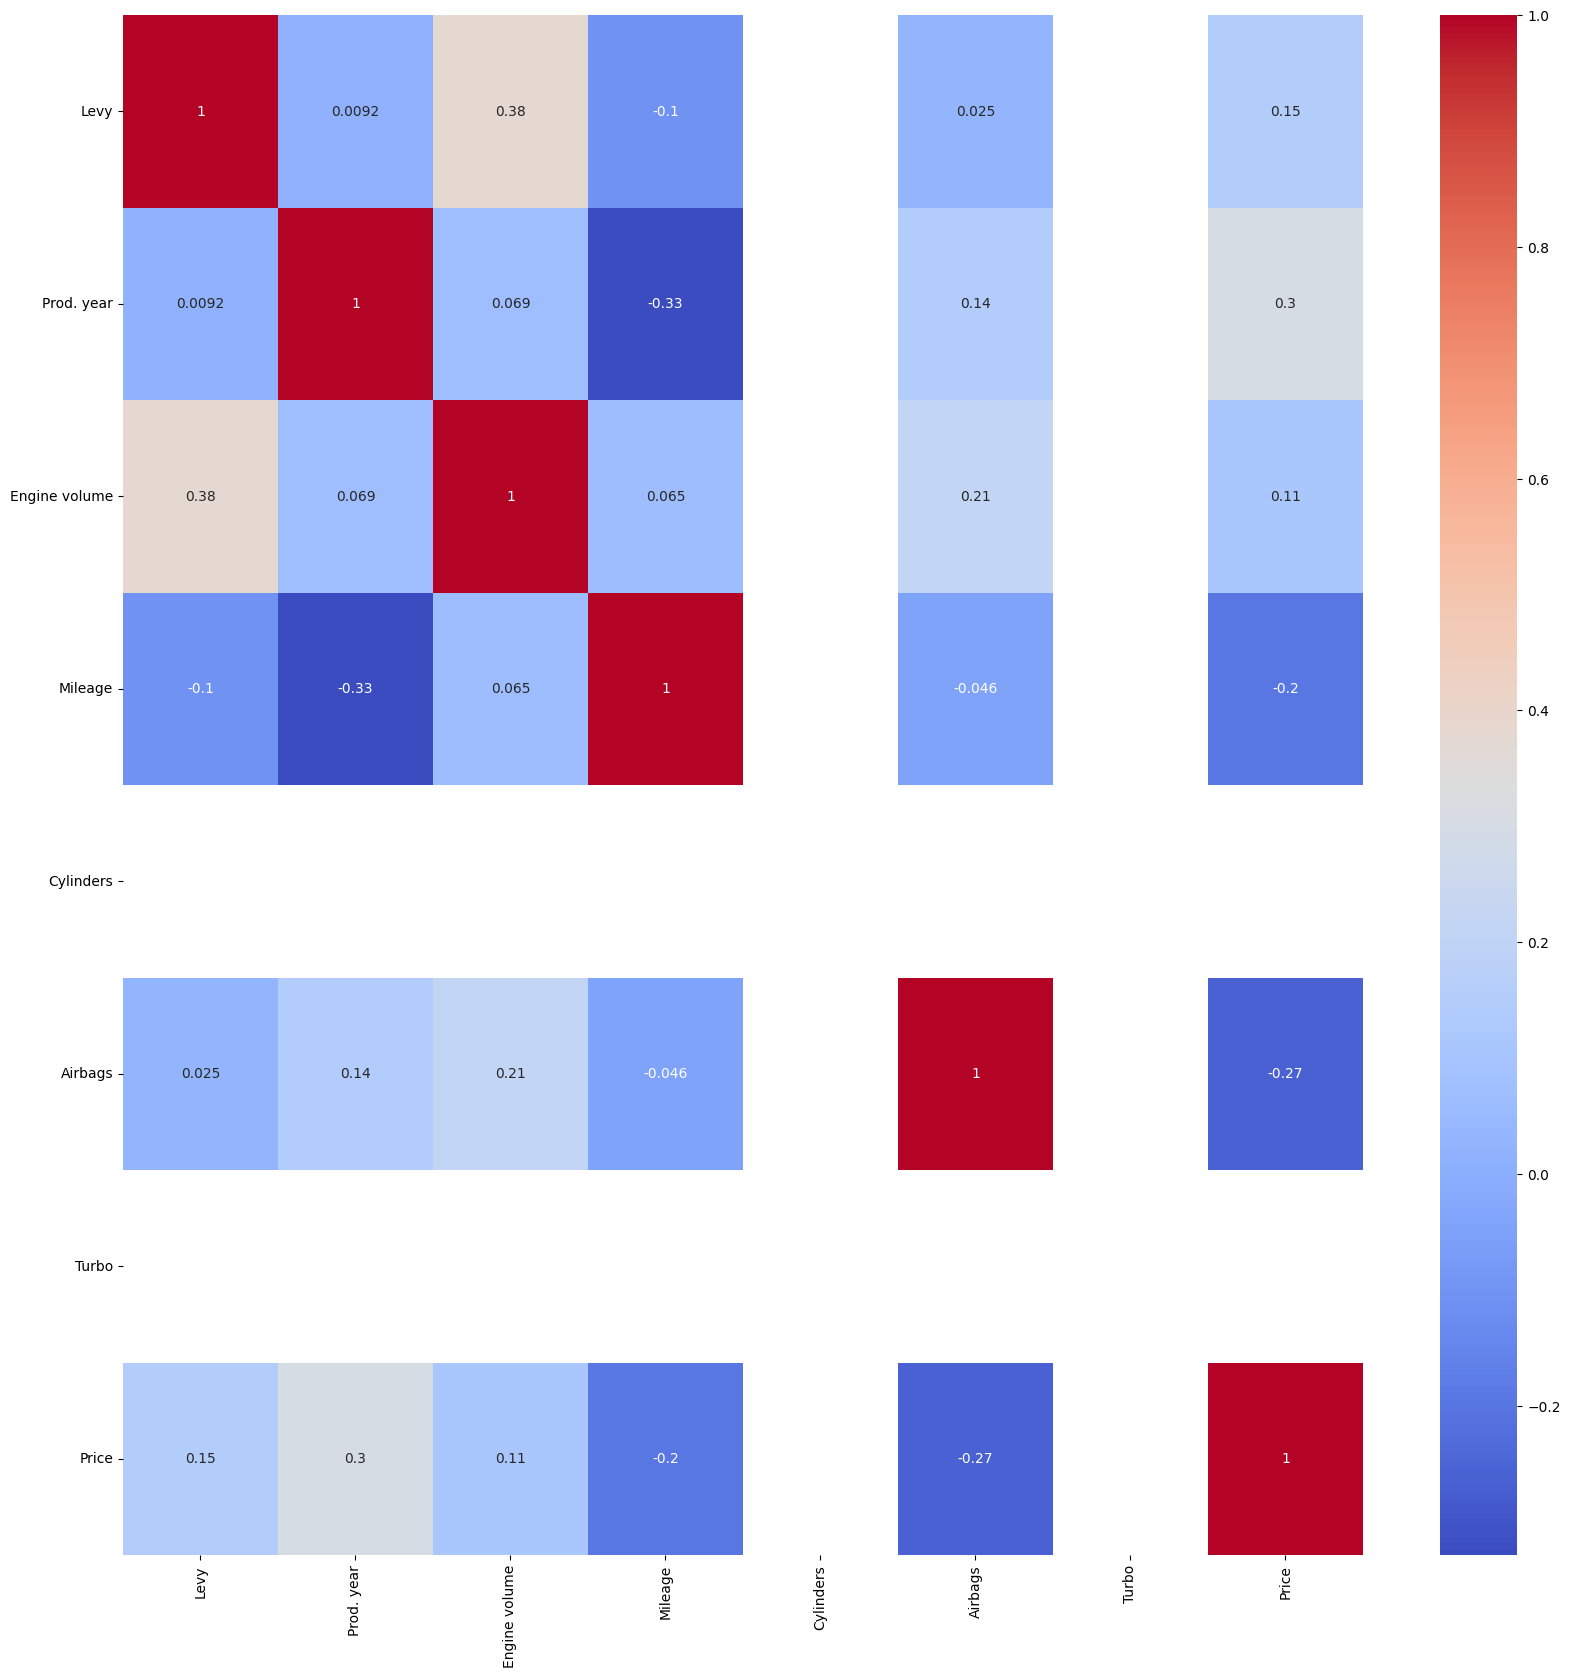

In [141]:
# 3.4 Correlation matrix
corr_matrix = data_no_outliers.corr(numeric_only=True)
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["Price"].sort_values(ascending=False)) # print correlation b/w a feature and other features

columns = list(corr_matrix.columns)

columns.remove('Price')
columns.append('Price')
corr_matrix = corr_matrix.loc[columns, columns]

# Create a heatmap from the correlation matrix
plt. figure(figsize=(20, 20))
sns. heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=90, fontsize=10)
# Rotate y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [142]:
data_no_outliers.describe()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,8106.000000,8106.000000,8106.000000,8106.000000,8106.000000,8106.0,8106.000000,8106.0
mean,17472.718110,757.585862,2013.380459,1.969418,113930.492351,4.0,6.260794,0.0
std,12455.533477,231.642750,2.650915,0.385785,64895.607275,0.0,4.004665,0.0
min,549.000000,247.000000,2005.000000,0.800000,0.000000,4.0,0.000000,0.0
25%,8154.000000,607.000000,2012.000000,1.600000,65155.250000,4.0,4.000000,0.0
50%,15681.000000,753.000000,2013.000000,2.000000,109000.000000,4.0,4.000000,0.0
75%,23644.750000,880.000000,2015.000000,2.400000,152511.000000,4.0,12.000000,0.0
max,52106.000000,1659.000000,2020.000000,3.500000,320000.000000,4.0,16.000000,0.0


In [148]:
# 4.2 Split training - test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_no_outliers, test_size=0.2, random_state=42) # set random_state to get the same training set all the time, 
																					# otherwise, when repeating training many times, your model may see all the data
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(test_set.head(4))
test_set.describe()


____________ Split training and test set ____________
6484 training + 1622 test examples
       Price  Levy Manufacturer     Model  Prod. year   Category  \
6282   33409   640      HYUNDAI  Santa FE        2013       Jeep   
14737  28241   528      HYUNDAI   Elantra        2014      Sedan   
10198   7213  1486        HONDA       FIT        2010  Hatchback   
2627   17876   333         FORD    Fusion        2014      Sedan   

      Leather interior Fuel type  Engine volume  Mileage  Cylinders  \
6282               Yes    Diesel            2.0   207187        4.0   
14737              Yes    Petrol            1.6   112843        4.0   
10198               No    Petrol            1.3     9200        4.0   
2627                No    Hybrid            2.0   110200        4.0   

      Gear box type Drive wheels   Doors             Wheel  Color  Airbags  \
6282      Automatic        Front  04-May        Left wheel  Black        4   
14737     Automatic        Front  04-May        Left whee

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Turbo
count,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.0,1622.000000,1622.0
mean,17447.407522,760.921702,2013.379162,1.964550,113738.225031,4.0,6.170777,0.0
std,12517.689239,226.311650,2.648177,0.384999,64636.894091,0.0,4.028867,0.0
min,549.000000,259.000000,2005.000000,1.000000,0.000000,4.0,0.000000,0.0
25%,7840.000000,629.000000,2012.000000,1.600000,65406.000000,4.0,4.000000,0.0
50%,15681.000000,761.000000,2013.000000,2.000000,107877.000000,4.0,4.000000,0.0
75%,24415.000000,880.000000,2015.000000,2.400000,154272.000000,4.0,12.000000,0.0
max,52034.000000,1659.000000,2020.000000,3.500000,318677.000000,4.0,16.000000,0.0


In [144]:
#%% 4.3 Separate labels from data, since we do not process label values
train_set_labels = train_set["Price"].copy()
train_set = train_set.drop(columns = "Price") 
test_set_labels = test_set["Price"].copy()
test_set = test_set.drop(columns = "Price") 


In [145]:
# 4.4 Define pipelines for processing data. 
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values         

# categorical pipelines
cat_pipeline = Pipeline([
    ('selector', ColumnSelector(cat_cols)),
    ('imputer', SimpleImputer(missing_values="-", strategy="constant", fill_value = "NO INFO", copy=True)), # complete missing values. copy=False: imputation will be done in-place 
    ('cat_encoder', OneHotEncoder()) # convert categorical data into one-hot vectors
    ])    

# # 4.4.3 Define MyFeatureAdder: a transformer for adding features "TOTAL NUMBER OF BEDROOMS",...  
# class MyFeatureAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_TOTAL_NO_OF_ROOMS = True): # MUST NO *args or **kargs
#         self.add_TOTAL_NO_OF_ROOMS = add_TOTAL_NO_OF_ROOMS
#     def fit(self, feature_values, labels = None):
#         return self  # nothing to do here
#     def transform(self, feature_values, labels = None):
#         if self.add_TOTAL_NO_OF_ROOMS:        
#             NO_OF_ROOMS_id, NO_OF_TOILETS_id = 1, 2 # column indices in num_feat_names. can't use column names b/c the transformer SimpleImputer removed them
#             # NOTE: a transformer in a pipeline ALWAYS return dataframe.values (ie., NO header and row index)
            
#             TOTAL_NO_OF_ROOMS = feature_values[:, NO_OF_ROOMS_id] + feature_values[:, NO_OF_TOILETS_id]
#             feature_values = np.c_[feature_values, TOTAL_NO_OF_ROOMS] #concatenate np arrays
#         return feature_values


# 4.4.4 Pipeline for numerical features
num_cols.remove("Price")
print(num_cols)
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_cols)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median", copy=True)), # copy=False: imputation will be done in-place 
    # ('attribs_adder', MyFeatureAdder(add_TOTAL_NO_OF_ROOMS = True)),
    ('std_scaler', StandardScaler(with_mean=True, with_std=True, copy=True)) # Scale features to zero mean and unit variance
    ])  

  
# 4.4.5 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline) ])  


# # 4.5 Run the pipeline to process training data           
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())
print(processed_train_set_val.shape)
# print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' %(len(num_cols)))
# joblib.dump(full_pipeline, r'models/full_pipeline.pkl')

['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Turbo']

____________ Processed feature values ____________
[[-0.49260306 -0.52073622  0.07607962 ...  0.          1.
   0.        ]
 [-0.0161039  -0.52073622  1.11242473 ...  0.          1.
   0.        ]
 [-1.73321799  0.61065671 -0.44209293 ...  0.          1.
   0.        ]]
(6484, 475)


In [146]:
# # (optional) Add header to create dataframe. Just to see. We don't need header to run algorithms 
# onehot_cols = []
# for val_list in full_pipeline.transformer_list[1][1].named_steps['cat_encoder'].categories_: 
# 	onehot_cols = onehot_cols + val_list.tolist()
# columns_header = train_set.columns.tolist() + ["TOTAL NUMBER OF BEDROOMS"] + onehot_cols
# for name in cat_feat_names:
# 	columns_header.remove(name)
# processed_train_set = pd.DataFrame(processed_train_set_val.toarray(), columns = columns_header)
# print('\n____________ Processed dataframe ____________')
# print(processed_train_set.info())
# print(processed_train_set.head())
